In [32]:
### network
import hdbscan
from sklearn.datasets import make_blobs

data, _ = make_blobs(1000)

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(data)
cluster_labels

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,

In [33]:
######################################
### Preload library and preparation ###
######################################
### library ###
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# auto reload the objects
# %load_ext autoreload
# %autoreload 2
import re
import pandas as pd
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
import numpy as np
import os
#os.getcwd()
# enable interactive plotly in notebook
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
#from umap import UMAP
import sklearn.datasets
from scipy.stats import stats
import requests
import pandas as pd
from matplotlib import pyplot as plt

import datetime
from datetime import timedelta
import math

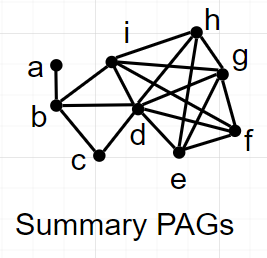

In [34]:
### connectivity

pd_map=pd.DataFrame([['a','b',1],
['b','c',1],
 ['b','d',1],
 ['b','i',1],
 ['c','d',1],
 ['d','e',1],
 ['d','f',1],
 ['d','g',1],
 ['d','h',1],
 ['d','i',1],
 ['e','f',1],
 ['e','g',1],
 ['e','h',1],
 ['f','g',1],
 ['f','i',1],
 ['g','h',1],
 ['g','i',1],
 ['h','i',1]
])


In [35]:
pd_map

,0,1,2
0,a,b,1
1,b,c,1
2,b,d,1
3,b,i,1
4,c,d,1
...,...,...,...
13,f,g,1
14,f,i,1
15,g,h,1
16,g,i,1


In [47]:
from scipy.stats import hypergeom
def calculate_CoI(k_int,n_int,K_int,N_int):
    CoI=-hypergeom.logcdf(n_int-k_int,N_int, K_int, n_int)
    return(CoI)

    
import collections
def list_overlap(a,b):
    a_multiset = collections.Counter(a)
    b_multiset = collections.Counter(b)
    overlap = list((a_multiset & b_multiset).elements())
    a_remainder = list((a_multiset - b_multiset).elements())
    b_remainder = list((b_multiset - a_multiset).elements())
    score=(len(overlap)+0.1)/(len(a_remainder)+0.1)
    return(overlap, a_remainder, b_remainder,score)

# step 1: find and rank neighbors based on the scores inbound and outbound links
# input: current
def find_and_rank(current,neighbor_pd):
    c_neighbor = current.neighbor.iloc[0]
    neighbor_nodes = neighbor_pd[neighbor_pd.node.isin(c_neighbor)]
    neighbor_nodes[['ovlp','a_rmdr','b_rmdr','score']]= neighbor_nodes[['neighbor']].apply(lambda x: list_overlap(
        #list(set(x['neighbor'])-set(current.node.iloc[0])),c_neighbor),axis=1,result_type='expand'
        list(set(x['neighbor'])),list(set(c_neighbor).union(set(current.node.iloc[0])))),axis=1,result_type='expand'
    )
    neighbor_nodes=neighbor_nodes.sort_values(['score'],ascending=False)
    return(neighbor_nodes)


import copy
# step 2: merge current node and update the current set
def merge_and_update(current,selected,int_cnt):
    
    current_update=copy.deepcopy(current)
    int_cnt=int_cnt+len(list_overlap(list(selected.neighbor.iloc[0]),list(current_update.node.iloc[0]))[0])  
    # update current node set
    current_update.node.iloc[0].append(selected['node'].iloc[0])
    #print(current)
    # update current neighbor set
    current_update.neighbor.iloc[0]=list((set(current_update.neighbor.iloc[0])-set(current_update.node.iloc[0])).union(set(selected['a_rmdr'].iloc[0])))
    n_int = len(current_update.node.iloc[0])*(len(current_update.node.iloc[0])-1)/2     
    CoI=calculate_CoI(np.int(int_cnt),np.int(n_int),np.int(K_int),np.int(N_int))
    #print(current_update)       
    return(current_update,CoI,int_cnt)

### initiate the neighbor dataframe ###
neighbor_set=[]
node_set=[]
degree_set=[]
edge_set=[]
all_nodes=set(set(pd_map[0].values).union(set(pd_map[1].values)))
for i in all_nodes:
    neighbors=list(pd_map[pd_map[0].isin([i])][1]) + list(pd_map[pd_map[1].isin([i])][0])
    neighbor_set.append(neighbors)
    node_set.append(i)
    edge_set.append([])
    degree_set.append(len(neighbors))
neighbor_pd=pd.DataFrame({'node':node_set,'neighbor':neighbor_set,'degree':degree_set,'edgeset':edge_set})
neighbor_pd['CoI'] = 0
### values ###
K_int=pd_map.shape[0]
N_int=len(all_nodes)*(len(all_nodes)-1)/2

# the initial seed node set with the node of the largest degree
neighbor_pd = neighbor_pd.sort_values('degree',ascending=False)
init_node = neighbor_pd.iloc[0:1,]


int_cnt=0
CoI=0
CoI_pre = 0.0
current=init_node
current['node'] = list([[current['node'].iloc[0]]])

rslt_sets=pd.DataFrame()

rmng = all_nodes
while len(current.neighbor.iloc[0])!=0:
    neighbor_nodes = find_and_rank(current,neighbor_pd) 
    print(f"current set: {type(current)}, neighbor set: {neighbor_nodes}") 
    selected=neighbor_nodes[0:1]
    (current_update,CoI,int_cnt) = merge_and_update(current,selected,int_cnt)
    print("CoI:%s" %str(CoI))
    
    if CoI_pre<CoI:
        CoI_pre = CoI
        ### update the current node table
        current = current_update
    else:
        ### trace back to the previous stage
        current.node.iloc[0] = list(set(current.node.iloc[0])-set(current.neighbor.iloc[0]))
        current['CoI'] = CoI_pre
        ### save result
        rslt_sets = pd.concat([rslt_sets,current])
        ### Reinitiate the parameters for another round
        #print("next round:")
        int_cnt=0
        CoI=0
        CoI_pre = 0.0
        rmng=list(set(rmng) - set(current.node.iloc[0]))
        if len(rmng)>0:
            current = neighbor_pd[neighbor_pd.node.isin(rmng)].iloc[0:1,]
            current['node'] = list([[current['node'].iloc[0]]])
        else:
            break


current set: <class 'pandas.core.frame.DataFrame'>, neighbor set:   node         neighbor  degree edgeset  CoI             ovlp a_rmdr              b_rmdr      score
2    i  [b, d, f, g, h]       5      []    0  [f, d, h, g, b]     []           [c, i, e]  51.000000
4    g  [h, i, d, e, f]       5      []    0  [f, i, d, h, e]     []           [g, c, b]  51.000000
0    f     [g, i, d, e]       4      []    0     [i, d, g, e]     []        [f, c, h, b]  41.000000
5    e     [f, g, h, d]       4      []    0     [h, f, g, d]     []        [c, i, e, b]  41.000000
6    h     [i, d, e, g]       4      []    0     [i, d, g, e]     []        [f, c, h, b]  41.000000
1    c           [d, b]       2      []    0           [d, b]     []  [g, f, c, i, h, e]  21.000000
7    b     [c, d, i, a]       4      []    0        [c, i, d]    [a]     [g, f, h, e, b]   2.818182
CoI:0.6931471805599462
current set: <class 'pandas.core.frame.DataFrame'>, neighbor set:   node         neighbor  degree edgeset  CoI 

/var/folders/nl/494sqlsd61v8pjn996vrm59r0000gn/T/ipykernel_86278/285851026.py:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nl/494sqlsd61v8pjn996vrm59r0000gn/T/ipykernel_86278/285851026.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nl/494sqlsd61v8pjn996vrm59r0000gn/T/ipykernel_86278/285851026.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [37]:
rslt_sets

,node,neighbor,degree,edgeset,CoI
3,"[f, i, d, g, e, h]","[c, b]",7,[],8.312301
7,"[c, b]","[i, d, a]",4,[],0.693147
8,"[a, b]","[c, i, d]",1,[],0.693147


In [38]:
rmng


[]

In [39]:
### result node set 
current


,node,neighbor,degree,edgeset,CoI
8,"[a, b]","[c, i, d]",1,[],0.693147


In [40]:
neighbor_pd[neighbor_pd.node.isin(rmng)]

,node,neighbor,degree,edgeset,CoI


In [41]:
neighbor_pd[neighbor_pd.node.isin(rmng)]

,node,neighbor,degree,edgeset,CoI


In [ ]:
import networkx as nx
import math

def jaccard_similarity(graph, nodeset1, nodeset2):
    """Calculate Jaccard Similarity between two sets of nodes."""
    intersection = len(set(nodeset1).intersection(set(nodeset2)))
    union = len(set(nodeset1).union(set(nodeset2)))
    return intersection / union if union != 0 else 0

def overlap_coefficient(graph, nodeset1, nodeset2):
    """Calculate Overlap Coefficient between two sets of nodes."""
    intersection = len(set(nodeset1).intersection(set(nodeset2)))
    min_set_size = min(len(nodeset1), len(nodeset2))
    return intersection / min_set_size if min_set_size != 0 else 0

def sorensen_dice_coefficient(graph, nodeset1, nodeset2):
    """Calculate Sørensen–Dice Coefficient between two sets of nodes."""
    intersection = len(set(nodeset1).intersection(set(nodeset2)))
    sum_set_sizes = len(nodeset1) + len(nodeset2)
    return (2 * intersection) / sum_set_sizes if sum_set_sizes != 0 else 0

def cosine_similarity_sets(graph, nodeset1, nodeset2):
    """Calculate Cosine Similarity between two sets of nodes, treated as binary vectors."""
    intersection = len(set(nodeset1).intersection(set(nodeset2)))
    product_set_sizes = math.sqrt(len(nodeset1) * len(nodeset2))
    return intersection / product_set_sizes if product_set_sizes != 0 else 0



# Example usage
G = nx.Graph()
# Add some example edges (or nodes) to your graph
G.add_edges_from([('a', 'b'), ('b', 'c'), ('c', 'd'), ('e', 'f'), ('f', 'g')])

# Define two sets of nodes to compare
nodeset1 = {'a', 'b', 'c'}
nodeset2 = {'b', 'c', 'd', 'e'}

# Calculate similarities
jaccard = jaccard_similarity(G, nodeset1, nodeset2)
overlap = overlap_coefficient(G, nodeset1, nodeset2)
dice = sorensen_dice_coefficient(G, nodeset1, nodeset2)
cosine = cosine_similarity_sets(G, nodeset1, nodeset2)

print("Jaccard Similarity:", jaccard)
print("Overlap Coefficient:", overlap)
print("Sørensen–Dice Coefficient:", dice)
print("Cosine Similarity:", cosine)
